## Obtain protein-coding paralog pairs set from Ensembl v.93

**Input:** 
- Ensembl list of paralogs
- Gene CDS length from Ensembl
- WGD data
- processed HGNC annotations

**Output:** All protein coding paralog pairs with some basic annotations - SORTED ON A1, A2

Ensembl release 93: http://jul2018.archive.ensembl.org/index.html

Notes:  
- ENSEMBL paralog data is listed as symmetric paralog pairs.
- The sequence identity of a paralog pair is not symmetric because the paralogs may have different lengths. 

Ensembl Filters: 
- Paralogous Human Genes: Only
- Gene type: protein_coding

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import networkx as nx
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

ensembl_version = '93'

# Inputs
file_ensembl_data = get_data_path(['ensembl', ensembl_version], 'paralog_pairs.txt')
file_cds_length = get_data_path(['ensembl', ensembl_version], 'gene_cds_length.txt')
file_singh_wgds = get_data_path(['WGD_sources','singh_2019'], 'hsapiens.Pairs.Strict.2R.txt')
file_makino_wgds = get_data_path(['WGD_sources'], 'makino_2010_ohnologs.xls')
file_id_map = get_local_data_path(['processed'], 'HGNC_gene_id_map.csv')

# Outputs
file_all_pairs = get_local_data_path(['processed', 'ensembl'+ensembl_version], 'all_pairs.csv')
file_unique_pairs = get_local_data_path(['processed', 'ensembl'+ensembl_version], 'unique_pairs.csv')

### Protein-coding paralog pairs w/ sequence identity

In [3]:
raw_data = pd.read_csv(file_ensembl_data)
raw_data[:1]

,Gene stable ID,Human paralogue gene stable ID,Paralogue %id. target Human gene identical to query gene,Paralogue last common ancestor with Human
0,ENSG00000276256,ENSG00000278198,83.3333,Homininae


In [4]:
# Clean up column names
data = raw_data.rename(columns={
    'Gene stable ID': 'A1_ensembl',
    'Human paralogue gene stable ID': 'A2_ensembl',
    'Paralogue %id. target Human gene identical to query gene': 'sequence_identity'
})
data = data[['A1_ensembl','A2_ensembl', 'sequence_identity']].drop_duplicates().reset_index(drop=True)
data.sequence_identity = data.sequence_identity / 100

# Drop non-symmetric pairs - i.e. cases where A2 is non-protein-coding in Ensembl
data = data[data.A2_ensembl.isin(data.A1_ensembl)].reset_index(drop=True)

print('N:', data.shape[0])
data[:2]

N: 91190


,A1_ensembl,A2_ensembl,sequence_identity
0,ENSG00000276256,ENSG00000278198,0.833333
1,ENSG00000276256,ENSG00000273496,0.833333


#### Filter on protein-coding

In [5]:
# Annotate with HGNC locus type - merge on Ensembl ID
id_map = pd.read_csv(file_id_map).dropna(subset=['ensembl_id'])[['locus_type', 'ensembl_id']]
df = pd.merge(data, id_map.rename(columns={'ensembl_id':'A1_ensembl'}), on=['A1_ensembl'])
df = pd.merge(df, id_map.rename(columns={'ensembl_id':'A2_ensembl'}), on=['A2_ensembl'])
print('N pairs in HGNC:', df.shape[0])
display(df[:1])

# Only keep pairs where A1 and A2 are both protein-coding in HGNC
coding_pairs = df[(df.locus_type_x == 'gene with protein product') & (df.locus_type_y == 'gene with protein product')]
coding_pairs = coding_pairs.drop(columns=['locus_type_x', 'locus_type_y']).drop_duplicates().reset_index(drop=True)
print('N pairs HGNC coding (symmetric):', coding_pairs.shape[0])
print('Protein coding genes w/ a paralog in Ensembl:', coding_pairs.A1_ensembl.nunique())
display(coding_pairs[:1])

N pairs in HGNC: 86918


,A1_ensembl,A2_ensembl,sequence_identity,locus_type_x,locus_type_y
0,ENSG00000274847,ENSG00000163060,0.79845,pseudogene,gene with protein product


N pairs HGNC coding (symmetric): 83404
Protein coding genes w/ a paralog in Ensembl: 13663


,A1_ensembl,A2_ensembl,sequence_identity
0,ENSG00000092850,ENSG00000163060,0.293023


#### Filter on sequence identity

In [6]:
# Sort coding pairs ids to determine min/max sequence identity
sorted_pairs = pd.concat([pd.DataFrame(np.sort(coding_pairs[['A1_ensembl','A2_ensembl']]), columns=['A1_sorted','A2_sorted']), 
                          coding_pairs[['A1_ensembl','A2_ensembl','sequence_identity']]], axis=1)
# Expect each pair to be in the list twice
assert(sorted_pairs.duplicated(subset=['A1_sorted','A2_sorted']).sum() * 2 == coding_pairs.shape[0])

# Get min/max sequence identity for each pair
sorted_pairs['min_seq_id'] = sorted_pairs.groupby(['A1_sorted','A2_sorted']).sequence_identity.transform('min')
sorted_pairs['max_seq_id'] = sorted_pairs.groupby(['A1_sorted','A2_sorted']).sequence_identity.transform('max')

# Drop pairs with max_seq_id < 20%
sorted_pairs_min20 = sorted_pairs[sorted_pairs.max_seq_id>=0.2].reset_index(drop=True)

print('Protein coding pairs w/ >=20% sequence identity (unique):', 
      sorted_pairs_min20.drop_duplicates(subset=['A1_sorted','A2_sorted']).shape[0])

# Go back to full (symmetric) list
all_pairs = sorted_pairs_min20.drop(columns=['A1_sorted','A2_sorted'])
display(all_pairs[:1])

Protein coding pairs w/ >=20% sequence identity (unique): 36648


,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023


### Add annotations

#### 1. Duplication mode - union of WGDs from two sources

In [7]:
singh_wgd_raw = pd.read_csv(file_singh_wgds, sep='\t')
display(singh_wgd_raw[:1])

# Make list symmetric for merging with all pairs
singh_wgd = pd.DataFrame(np.sort(singh_wgd_raw[['Ohno1', 'Ohno2']]), columns=['Ohno1','Ohno2']).drop_duplicates()
print('N Singh WGDs:', singh_wgd.shape[0])
singh_wgd = pd.concat([singh_wgd, singh_wgd.rename(columns={'Ohno1':'Ohno2','Ohno2':'Ohno1'})])
singh_wgd = singh_wgd.rename(columns={'Ohno1':'A1_ensembl', 'Ohno2':'A2_ensembl'})
display(singh_wgd[:1])

,Ohno1,Ohno2,Symbol1,Symbol2,Og weighted global mean,Self weighted global mean,Outgroup Support,Duplication time,Gene type
0,ENSG00000164236,ENSG00000167612,ANKRD33B,ANKRD33,0.000159,1.329170e-08,2.0,Vertebrata,protein_coding


N Singh WGDs: 4254


,A1_ensembl,A2_ensembl
0,ENSG00000164236,ENSG00000167612


In [8]:
makino_wgd_raw = pd.read_excel(file_makino_wgds, skiprows=1, skipfooter=3, sheet_name='Table S7')
display(makino_wgd_raw[:1])
makino_wgd = makino_wgd_raw.rename(columns={'Ohnolog1':'Ohno1','Ohnolog2':'Ohno2'})

# Make list symmetric for merging with all pairs
makino_wgd = pd.DataFrame(np.sort(makino_wgd[['Ohno1', 'Ohno2']]), columns=['Ohno1', 'Ohno2']).drop_duplicates()
print('N Makino WGDs:', makino_wgd.shape[0])
makino_wgd = pd.concat([makino_wgd, makino_wgd.rename(columns={'Ohno1':'Ohno2','Ohno2':'Ohno1'})])
makino_wgd = makino_wgd.rename(columns={'Ohno1':'A1_ensembl', 'Ohno2':'A2_ensembl'})
display(makino_wgd[:1])

,Ohnolog1,chr_ohno1,Position1,Ohnolog2,chr_ohno2,Position2,C_int,C_sav,Amphi,Sea_u,Fly,Worm
0,ENSG00000130762,1,3361100,ENSG00000142632,1,16411691,None,None,None,Ohno,Ohno,None


N Makino WGDs: 9057


,A1_ensembl,A2_ensembl
0,ENSG00000130762,ENSG00000142632


In [9]:
# Merge both WGD sets with all pairs
pairs_annot = pd.merge(all_pairs, singh_wgd, how='left', indicator='singh_wgd')
pairs_annot = pd.merge(pairs_annot, makino_wgd, how='left', indicator='makino_wgd')
pairs_annot.singh_wgd = pairs_annot.singh_wgd=='both'
pairs_annot.makino_wgd = pairs_annot.makino_wgd == 'both'
pairs_annot['WGD'] = (pairs_annot.singh_wgd | pairs_annot.makino_wgd)

print('N Singh WGD:', int(pairs_annot[pairs_annot.singh_wgd].shape[0]/2))
print('N Makino WGD:', int(pairs_annot[pairs_annot.makino_wgd].shape[0]/2))
print('N either WGD:', int(pairs_annot[pairs_annot.WGD].shape[0]/2))
pairs_annot[:1]

N Singh WGD: 3895
N Makino WGD: 6117
N either WGD: 7036


,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True


#### 2. Location (Chromosome)

In [10]:
# Get gene location from HGNC
id_map = pd.read_csv(file_id_map).dropna(subset=['ensembl_id'])[['ensembl_id', 'location']]

pairs_annot2 = pd.merge(pairs_annot, id_map.rename(columns={'ensembl_id':'A1_ensembl', 'location':'A1_chr'}))
pairs_annot2 = pd.merge(pairs_annot2, id_map.rename(columns={'ensembl_id':'A2_ensembl','location':'A2_chr'}))

# Reduce location to chr number (if possible)
def get_chr(x):
    if str(x) == 'nan': return 'NA'
    res = re.search('([\dXY]+)[qp]', x)
    if not res: return x
    return res.group(1)

pairs_annot2.A1_chr = pairs_annot2.A1_chr.apply(get_chr)
pairs_annot2.A2_chr = pairs_annot2.A2_chr.apply(get_chr)

# Whether genes in pair are on same chromosome
pairs_annot2 = pairs_annot2.assign(same_chr = (pairs_annot2.A1_chr == pairs_annot2.A2_chr)).drop(columns=['A1_chr','A2_chr'])
pairs_annot2[:2]

,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True,False
1,ENSG00000167858,ENSG00000163060,0.375598,0.360920,0.375598,False,True,True,False


#### 3. Closest pair (highest sequence identity)

In [11]:
# Find closest A2 for each A1
max_per_A1 = pairs_annot2.groupby('A1_ensembl').sequence_identity.max().reset_index()
pairs_annot3 = pd.merge(pairs_annot2, max_per_A1, how='left', indicator='closest')

# Annotate pairs as closest if A2 is A1's closest paralog (in terms of sequence identity)
pairs_annot3['closest'] = pairs_annot3['closest'] == 'both'
pairs_annot3[:2]

,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True,False,False
1,ENSG00000167858,ENSG00000163060,0.375598,0.360920,0.375598,False,True,True,False,True


#### 4. Family size

In [12]:
# Set of all paralogs for each A1
paralog_families = pairs_annot3.groupby('A1_ensembl').agg({'A2_ensembl':set}).reset_index()
paralog_families = paralog_families.rename(columns={'A1_ensembl':'gene', 'A2_ensembl':'paralogs'})
display(paralog_families[:1])

# Family size = union of all A1 and all A2 paralogs
df = pd.merge(pairs_annot3[['A1_ensembl','A2_ensembl']], paralog_families.rename(columns={'gene':'A1_ensembl'}))
df = pd.merge(df, paralog_families.rename(columns={'gene':'A2_ensembl'}), on=['A2_ensembl'])
df['family'] = df.apply(lambda x: frozenset(x.paralogs_x.union(x.paralogs_y)), axis=1)
df['family_size'] = df.apply(lambda x: len(x.paralogs_x.union(x.paralogs_y)), axis=1)
df = df.drop(columns=['paralogs_x','paralogs_y'])

# Identify the unique families - assign an id to each
families = pd.DataFrame(df.family.unique(), columns=['family']).reset_index().rename(columns={'index':'family_id'})
print('N unique families:', families.shape[0])
df = pd.merge(df, families)
display(df[:1])

pairs_annot4 = pd.merge(pairs_annot3, df.drop(columns=['family']), how='left')
display(pairs_annot4[:1])

,gene,paralogs
0,ENSG00000000003,"{ENSG00000140391, ENSG00000158457, ENSG0000009..."


N unique families: 4341


,A1_ensembl,A2_ensembl,family,family_size,family_id
0,ENSG00000092850,ENSG00000163060,"(ENSG00000092850, ENSG00000167858, ENSG0000012...",5,0


,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,family_id
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True,False,False,5,0


#### 5. CDS length

In [13]:
cds_length = pd.read_csv(file_cds_length).rename(columns={'CDS Length':'cds_length'}).dropna(subset=['cds_length'])
assert(pairs_annot4[~pairs_annot4.A1_ensembl.isin(cds_length['Gene stable ID'])].A1_ensembl.nunique() == 0)
display(cds_length[:1])

# Filter and consider CDS length to be that of longest transcript
cds_length = cds_length[cds_length['Gene stable ID'].isin(pairs_annot4.A1_ensembl)].reset_index(drop=True)
cds_length = cds_length.groupby('Gene stable ID').cds_length.max().reset_index()

# Get length of each gene and compute ratio min/max
df = pd.merge(pairs_annot4, cds_length.rename(columns={'Gene stable ID':'A1_ensembl', 'cds_length':'A1_length'}))
df = pd.merge(df, cds_length.rename(columns={'Gene stable ID':'A2_ensembl', 'cds_length':'A2_length'}))
df['cds_length_ratio'] = df.apply(lambda x: min(x.A1_length, x.A2_length) / max(x.A1_length, x.A2_length), axis=1)

pairs_annot5 = df.drop(columns=['A1_length','A2_length'])
display(pairs_annot5[:1])

,Gene stable ID,cds_length
0,ENSG00000276256,363.0


,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,family_id,cds_length_ratio
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True,False,False,5,0,0.988532


#### 6. Add symbols and entrez id from HGNC

In [14]:
id_map = pd.read_csv(file_id_map).dropna(subset=['ensembl_id'])[['symbol','entrez_id','ensembl_id']]

# Merge symbols + entrez
df = pd.merge(pairs_annot5, id_map.rename(columns={'symbol':'A1','ensembl_id':'A1_ensembl','entrez_id':'A1_entrez'}))
df = pd.merge(df, id_map.rename(columns={'symbol':'A2','ensembl_id':'A2_ensembl','entrez_id':'A2_entrez'}))
all_pairs_annot = df.astype({'A1_entrez':'int', 'A2_entrez':'int'})

print('Num pairs min. 20%:', int(all_pairs_annot.shape[0]/2))
print('Num paralog genes min. 20%:', pd.concat([all_pairs_annot.A1, all_pairs_annot.A2]).nunique())
display(all_pairs_annot[:2])

Num pairs min. 20%: 36648
Num paralog genes min. 20%: 13320


,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,family_id,cds_length_ratio,A1,A1_entrez,A2,A2_entrez
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True,False,False,5,0,0.988532,TEKT2,27285,TEKT4,150483
1,ENSG00000167858,ENSG00000163060,0.375598,0.360920,0.375598,False,True,True,False,True,5,0,0.961009,TEKT1,83659,TEKT4,150483


### Export data sets

In [15]:
all_pairs_annot.to_csv(file_all_pairs, index=0)

In [16]:
# Unique pairs (not symmetric)
df = pd.concat([pd.DataFrame(np.sort(all_pairs_annot[['A1','A2']]), columns=['A1','A2']),
                all_pairs_annot.drop(columns=['A1','A2','A1_ensembl','A2_ensembl','A1_entrez',
                                              'A2_entrez','sequence_identity'])], axis=1)

# All properties are symmetric/the same except for "closest"
# Closest if closest for both genes (min of bool)
unique_pairs = df.groupby(['A1','A2']).min().reset_index()
print('N unique pairs:', unique_pairs.shape[0])

# Add back other ids
unique_pairs = pd.merge(unique_pairs, id_map.rename(columns={'symbol':'A1','ensembl_id':'A1_ensembl','entrez_id':'A1_entrez'}))
unique_pairs = pd.merge(unique_pairs, id_map.rename(columns={'symbol':'A2','ensembl_id':'A2_ensembl','entrez_id':'A2_entrez'}))
unique_pairs = unique_pairs.astype({'A1_entrez':'int', 'A2_entrez':'int'})

assert(unique_pairs[(unique_pairs.family_size.isna()) & (unique_pairs.max_seq_id>=0.2)].shape[0]==0)

display(unique_pairs[:2])

N unique pairs: 36648


,A1,A2,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,family_id,cds_length_ratio,A1_entrez,A1_ensembl,A2_entrez,A2_ensembl
0,A1BG,OSCAR,0.127273,0.220280,False,False,False,True,False,3,3046,0.578629,1,ENSG00000121410,126014,ENSG00000170909
1,A1BG,TARM1,0.149495,0.265233,False,False,False,True,False,3,3046,0.564516,1,ENSG00000121410,441864,ENSG00000248385


In [17]:
unique_pairs.to_csv(file_unique_pairs)

### Families

In [18]:
# Check that all families are fully connected (need unfiltered on seq id data)
G = nx.Graph()
G.add_edges_from(coding_pairs[['A1_ensembl','A2_ensembl']].values)

In [19]:
def draw_family_network_for_gene(gene, G, ax):
    fam = paralog_families[paralog_families.gene==all_pairs_annot[all_pairs_annot.A1==gene].A1_ensembl.values[0]]
    fam_pairs = all_pairs_annot[all_pairs_annot.A1_ensembl.isin(fam.paralogs.values[0])]
    G = nx.Graph()
    G.add_edges_from(fam_pairs[['A1','A2']].values)
    nx.draw_networkx(G, node_color='silver', node_size=2000, ax=ax)
    ax.axis('off')
    ax.set_xlim([1.3*x for x in ax.get_xlim()])
    ax.set_ylim([1.3*y for y in ax.get_ylim()])

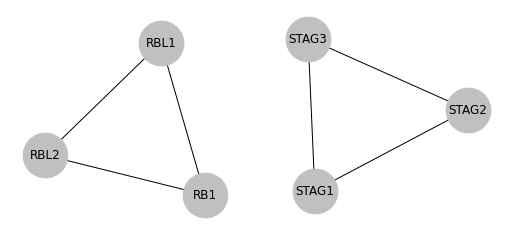

In [20]:
f, ax = plt.subplots(1, 2, figsize=(9,4))
draw_family_network_for_gene("RB1", G, ax[0])
draw_family_network_for_gene("STAG1", G, ax[1])